<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 37400 - Fixed Income</left> 
<br>
<left>Winter 2024</left>

<h2><center> Final Exam Study Guide</center></h2>

<h3><span style="color:#00008B">Name - Nick Lewis</span></h3>
<h3><span style="color:#00008B">Email - nicklewis16@uchicago.edu</span></h3>

# Imports and Helper Functions for Exam

In [2]:
import pandas as pd
import numpy as np
import datetime
import holidays

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
import warnings
from scipy.optimize import minimize
from scipy import interpolate
from scipy.optimize import fsolve
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

def bday(date):
    """
    Check if a given date is a business day in the US.

    Parameters:
    date (datetime.date): The date to check.

    Returns:
    bool: True if the date is a business day, False otherwise.
    """
    us_bus = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    return bool(len(pd.bdate_range(date, date, freq=us_bus)))

def prev_bday(date, force_prev=False):
    """
    Returns the previous business day given a date.

    Parameters:
    date (str or datetime.datetime): The input date in the format 'YYYY-MM-DD' or as a datetime object.
    force_prev (bool, optional): If True, forces the function to return the previous business day even if the input date is already a business day. Defaults to False.

    Returns:
    str or datetime.datetime: The previous business day as a string in the format 'YYYY-MM-DD' if the input date is a string, or as a datetime object if the input date is a datetime object.
    """
    if isinstance(date, str):
        date = datetime.datetime.strptime(date, '%Y-%m-%d')
        date2str = True
    else:
        date2str = False
        
    if force_prev:
        date += -datetime.timedelta(days=1)
    while not bday(date):
        date += -datetime.timedelta(days=1)
    
    if date2str:
        date = date.strftime('%Y-%m-%d')
        
    return date

def get_coupon_dates(quote_date, maturity_date):
    """
    Returns a list of coupon dates between the quote date and maturity date.

    Parameters:
    quote_date (str or datetime.datetime): The quote date in the format 'YYYY-MM-DD' or as a datetime object.
    maturity_date (str or datetime.datetime): The maturity date in the format 'YYYY-MM-DD' or as a datetime object.

    Returns:
    list: A list of coupon dates between the quote date and maturity date.
    """
    if isinstance(quote_date, str):
        quote_date = datetime.datetime.strptime(quote_date, '%Y-%m-%d')
        
    if isinstance(maturity_date, str):
        maturity_date = datetime.datetime.strptime(maturity_date, '%Y-%m-%d')
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date - quote_date).days / 180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out



def make_figure_number_issues_paying(CFmatrix):
    """
    Creates a figure showing the number of treasury issues with coupon or principal payment over time.

    Parameters:
    CFmatrix (numpy.ndarray): The cash flow matrix representing the treasury issues.

    Returns:
    None
    """
    mask_issues_paying = (CFmatrix!=0).sum()

    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(mask_issues_paying,marker='*',linestyle='None')

    #set ticks every quarter
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(2,5,8,11)))
    ax.xaxis.set_major_locator(mdates.YearLocator(month=2))

    #format ticks
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=60, horizontalalignment='right')

    ax.margins(x=0)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    plt.ylabel('number of treasury issues with coupon or principal payment')
    plt.title('Number of Treasuries Paying')

    plt.show()



def filter_treasuries(data, t_date=None, filter_maturity=None, filter_maturity_min=None, drop_duplicate_maturities=False, filter_tips=True, filter_yld=True):
    """
    Filter treasury data based on specified criteria.

    Parameters:
    - data: DataFrame, the treasury data to be filtered.
    - t_date: datetime, the date to filter the data on. If None, the latest date in the data will be used.
    - filter_maturity: int, the maximum maturity in years to filter the data on. Default is None.
    - filter_maturity_min: int, the minimum maturity in years to filter the data on. Default is None.
    - drop_duplicate_maturities: bool, whether to drop duplicate maturities. Default is False.
    - filter_tips: bool, whether to filter out TIPS (Treasury Inflation-Protected Securities). Default is True.
    - filter_yld: bool, whether to filter out securities with zero yield. Default is True.

    Returns:
    - outdata: DataFrame, the filtered treasury data.
    """
    outdata = data.copy()
    
    if t_date is None:
        t_date = outdata['CALDT'].values[-1]
    
    outdata = outdata[outdata['CALDT'] == t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['TMATDT'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['TMATDT'] < (t_date + np.timedelta64(365 * filter_maturity + 1, 'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['TMATDT'] > (t_date + np.timedelta64(365 * filter_maturity_min - 1, 'D'))
        outdata = outdata[mask_truncate]

    outdata = outdata[outdata['ITYPE'].isin([11, 12]) == (not filter_tips)]
        
    if filter_yld:
        outdata = outdata[outdata['TDYLD'] > 0]
        
    return outdata



def calc_cashflows(quote_data, filter_maturity_dates=False):
    """
    Calculate cashflows based on quote data.

    Args:
        quote_data (pd.DataFrame): DataFrame containing quote data.
        filter_maturity_dates (bool, optional): Flag to filter cashflows based on maturity dates. 
            Defaults to False.

    Returns:
        pd.DataFrame: DataFrame containing calculated cashflows.
    """
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100

    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    return CF


def check_dates(df):
    t_check = df['CALDT'].values[0]
    if df['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None
    return t_current

def data_summary(rdata, t_current):
    '''
    Performs calculations of process treasury quotes if filepath is different.
    Make sure ['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT'] are in the rdata
    
    '''
    res = rdata[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']].copy()
    #TDYLD: PROMISED YIELD DAILY RATE, ALSO CALLED DAILY YIELD TO MATURITY.
    #IF A PRICE IS MISSING, THE tdyld IS SET TO -99
    res.columns = ['issue date','maturity date','coupon rate','yld', 'duration','outstanding']
    res['yld'] *= 365
    #DURATION: THE DAILY SERIES OF THE WEIGHTED AVERAGE NUMBER OF DAYS UNTIL THE CASH FLOWS OCCUR, WHERE THE PRESENT VALUES, DISCOUNTED BY YIELD TO MATURITY, 
    #OF EACH PAYMENT ARE USED AS THE WEIGHTS.
    res['duration'] /= 365
    #outstanding: DAILY SERIES OF THE AMOUNT (FACE VALUE) HELD BY THE PUBLIC IN MILLIONS OF DOLLARS
    res['outstanding'] *= 1e6
    res['maturity'] = get_maturity_delta(res['maturity date'], t_current)
    #TDACCINT: DAILY SERIES OF TOTAL ACCRUED INTEREST
    res['price'] = (rdata['TDBID'] + rdata['TDASK'])/2 + rdata['TDACCINT']
    res['bid-ask'] = rdata['TDASK'] - rdata['TDBID']
    res['next cashflow'] = (calc_cashflow(rdata)!=0).idxmax(1)
    return res

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):
    """
    Filter treasury cashflows based on specified criteria.

    Parameters:
    CF (DataFrame): The cashflow data.
    filter_maturity_dates (bool): Flag indicating whether to filter by maturity dates. Default is False.
    filter_benchmark_dates (bool): Flag indicating whether to filter by benchmark dates. Default is False.
    filter_CF_strict (bool): Flag indicating whether to filter cashflows strictly. Default is True.

    Returns:
    DataFrame: The filtered cashflow data.
    """
    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered



def get_maturity_delta(t_maturity, t_current):
    """
    Calculates the maturity delta in years between the given maturity date and the current date.

    Parameters:
    t_maturity (datetime): The maturity date.
    t_current (datetime): The current date.

    Returns:
    float: The maturity delta in years.
    """
    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return maturity_delta



def discount_to_intrate(discount, maturity, n_compound=None):
    """
    Calculates the interest rate given the discount factor and maturity.

    Parameters:
    discount (float): The discount factor.
    maturity (float): The time to maturity in years.
    n_compound (int, optional): The number of times interest is compounded per year. 
                                If not provided, interest is continuously compounded.

    Returns:
    float: The interest rate.

    """
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate




def intrate_to_discount(intrate, maturity, n_compound=None):
    """
    Calculates the discount factor given an interest rate and maturity.

    Parameters:
    intrate (float): The interest rate.
    maturity (float): The time to maturity in years.
    n_compound (int, optional): The number of times interest is compounded per year. 
                                If not provided, the discount factor is calculated using continuous compounding.

    Returns:
    float: The discount factor.
    """
    
    if n_compound is None:
        discount = np.exp(-intrate * maturity)
    else:
        discount = 1 / (1+(intrate / n_compound))**(n_compound * maturity)

    return discount



def compound_rate(intrate, compound_input, compound_output):
    """
    Calculates the compound rate based on the given interest rate and compounding periods.

    Parameters:
    intrate (float): The interest rate.
    compound_input (float): The number of compounding periods for the input rate.
    compound_output (float): The number of compounding periods for the output rate.

    Returns:
    float: The compound rate.

    """
    if compound_input is None:
        outrate = compound_output * (np.exp(intrate/compound_output) - 1)
    elif compound_output is None:
        outrate = compound_input * np.log(1 + intrate/compound_input)
    else:
        outrate = ((1 + intrate/compound_input) ** (compound_input/compound_output) - 1) * compound_output

    return outrate







def bootstrap(params, maturity):
    """
    Calculates the interpolated interest rate for a given maturity using the bootstrap method.

    Parameters:
    params (tuple): A tuple containing the estimated maturities and betas.
    maturity (float): The maturity for which the interest rate needs to be calculated.

    Returns:
    float: The interpolated interest rate for the given maturity.
    """
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas, estimated_maturities)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate



def nelson_siegel(params, maturity):
    """
    Calculates the Nelson-Siegel interest rate based on the given parameters and maturity.

    Parameters:
    params (list): A list of parameters [a, b, c, d] used in the Nelson-Siegel formula.
    maturity (float): The time to maturity in years.

    Returns:
    float: The calculated Nelson-Siegel interest rate.
    """
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3])
    
    return rate





def nelson_siegel_extended(params, maturity):
    """
    Calculates the Nelson-Siegel Extended rate for a given set of parameters and maturity.

    Parameters:
    params (list): A list of parameters [param1, param2, param3, param4, param5, param6].
    maturity (float): The time to maturity in years.

    Returns:
    rate (float): The calculated Nelson-Siegel Extended rate.
    """
    rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3]) + params[4] *((1-np.exp(-maturity/params[5]))/(maturity/params[5]) - np.exp(-maturity/params[5]))
    
    return rate




def estimate_curve_ols(CF, prices, interpolate=False):
    """
    Estimates the curve using ordinary least squares (OLS) regression.

    Parameters:
        CF (pd.DataFrame or pd.Series): Cash flows.
        prices (pd.DataFrame or pd.Series or np.ndarray): Prices.
        interpolate (bool, optional): Whether to interpolate the curve. Defaults to False.

    Returns:
        np.ndarray: Estimated curve discounts.
    """

    if isinstance(prices, pd.DataFrame) or isinstance(prices, pd.Series):
        prices = prices[CF.index].values

    mod = LinearRegression(fit_intercept=False).fit(CF.values, prices)

    if interpolate:
        matgrid = get_maturity_delta(CF.columns, CF.columns.min())

        dts_valid = np.logical_and(mod.coef_ < 1.25, mod.coef_ > 0)

        xold = matgrid[dts_valid]
        xnew = matgrid
        yold = mod.coef_[dts_valid]

        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')
        discounts = f(xnew)

    else:
        discounts = mod.coef_

    return discounts




def price_with_rate_model(params, CF, t_current, fun_model, convert_to_discount=True, price_coupons=False):
    """
    Calculates the price of a fixed income security using a rate model.

    Parameters:
    params (list): List of parameters for the rate model.
    CF (numpy.ndarray): Cash flow of the fixed income security.
    t_current (float): Current time.
    fun_model (function): Function that models the interest rate.
    convert_to_discount (bool, optional): Flag to convert interest rates to discount factors. Defaults to True.
    price_coupons (bool, optional): Flag to include coupon payments in the price calculation. Defaults to False.

    Returns:
    numpy.ndarray: Price of the fixed income security.
    """

    maturity = get_maturity_delta(CF.columns, t_current)
    
    if convert_to_discount:
        disc = np.zeros(maturity.shape)
        for i, mat in enumerate(maturity):
            disc[i] = intrate_to_discount(fun_model(params,mat),mat)
    else:
        disc = fun(params,mat)
        
        
    if price_coupons:
        price = CF * disc
    else:
        price = CF @ disc
    
    return price




def pricing_errors(params, CF, t_current, fun_model, observed_prices):
    """
    Calculates the pricing errors between the observed prices and the modeled prices.

    Parameters:
    params (list): List of parameters for the rate model.
    CF (list): List of cash flows.
    t_current (float): Current time.
    fun_model (function): Function representing the rate model.
    observed_prices (array-like): Array-like object containing the observed prices.

    Returns:
    float: The sum of squared pricing errors.
    """
    price_modeled = price_with_rate_model(params, CF, t_current, fun_model)

    if isinstance(observed_prices, pd.DataFrame) or isinstance(observed_prices, pd.Series):
        observed_prices = observed_prices.values

    error = sum((observed_prices - price_modeled) ** 2)

    return error


def estimate_rate_curve(model, CF, t_current, prices, x0=None):
    """
    Estimates the rate curve parameters based on the given model.

    Parameters:
        model (str): The model used for estimation. Possible values are 'bootstrap', 'nelson_siegel', and 'nelson_siegel_extended'.
        CF (DataFrame): Cash flow matrix.
        t_current (float): Current time.
        prices (Series): Bond prices.
        x0 (array-like, optional): Initial guess for the optimization algorithm. Default is None.

    Returns:
        array-like: Optimized rate curve parameters.
    """
    if model is bootstrap:
        params = estimate_curve_ols(CF, prices, interpolate=False)
        
        CF_intervals = get_maturity_delta(CF.columns.to_series(), t_current=t_current).values
    
        params_optimized = [CF_intervals, params]

    else:
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones(4) / 10
            elif model is nelson_siegel_extended:
                x0 = np.ones(6)
            else:
                x0 = 1        

        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x

    return params_optimized



def extract_spot_curves(quote_date, filepath=None, model=nelson_siegel, delta_maturity = .25, T=30,calc_forward=False, delta_forward_multiple = 1, filter_maturity_dates=False, filter_tips=True):
    """
    Extracts spot curves from treasury quotes data.

    Parameters:
    - quote_date (str): The date of the treasury quotes.
    - filepath (str, optional): The file path of the treasury quotes data. If not provided, a default path will be used.
    - model (function, optional): The model used to estimate the rate curve. Default is nelson_siegel.
    - delta_maturity (float, optional): The increment between maturities in the maturity grid. Default is 0.25.
    - T (int, optional): The maximum maturity in the maturity grid. Default is 30.
    - calc_forward (bool, optional): Whether to calculate forward rates. Default is False.
    - delta_forward_multiple (int, optional): The multiple of delta_maturity used to calculate the delta forward. Default is 1.
    - filter_maturity_dates (bool, optional): Whether to filter maturity dates. Default is False.
    - filter_tips (bool, optional): Whether to filter TIPS (Treasury Inflation-Protected Securities). Default is True.

    Returns:
    - curves (DataFrame): DataFrame containing spot rates, spot discounts, and optionally forward rates and forward discounts.
    """
    if filepath is None:
        filepath = f'../data/treasury_quotes_{quote_date}.xlsx'
        
    rawdata = pd.read_excel(filepath,sheet_name='quotes')
    
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None

    rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
    rawprices.name = 'price'

    ###
    data = filter_treasuries(rawdata, t_date=t_current, filter_tips=filter_tips)

    CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=filter_maturity_dates)
    prices = rawprices[CF.index]

    ###
    params = estimate_rate_curve(model,CF,t_current,prices)
    
    if model == nelson_siegel_extended:
        params0 = estimate_rate_curve(nelson_siegel,CF,t_current,prices)
        x0 = np.concatenate((params0,(1,1)))
        params = estimate_rate_curve(model,CF,t_current,prices,x0=x0)
        
    else:
        params = estimate_rate_curve(model,CF,t_current,prices)

    ###
    maturity_grid = np.arange(0,T+delta_maturity,delta_maturity)
    maturity_grid[0] = .01
    
    curves = pd.DataFrame(index = pd.Index(maturity_grid,name='maturity'))
    # adjust earliest maturity from 0 to epsion
    curves.columns.name = quote_date
    
    curves['spot rate']= model(params,maturity_grid)

    curves['spot discount'] = intrate_to_discount(curves['spot rate'].values,curves.index.values)
    
    
    
    if calc_forward:
        delta_forward = delta_forward_multiple * delta_maturity
        
        curves['forward discount'] = curves['spot discount'] / curves['spot discount'].shift(delta_forward_multiple)

        # first value of forward is spot rate
        maturity_init = curves.index[0:delta_forward_multiple]
        curves.loc[maturity_init,'forward discount'] = curves.loc[maturity_init,'spot discount']
        
        curves.insert(2,'forward rate', -np.log(curves['forward discount'])/delta_forward)
        
    return curves



def process_treasury_quotes(quote_date):
    """
    Processes treasury quotes data and returns relevant metrics.

    Parameters:
    - quote_date (str): The date of the treasury quotes.

    Returns:
    - metrics (DataFrame): DataFrame containing metrics such as issue date, maturity date, outstanding, coupon rate, yield, duration, maturity interval, and price.
    """
    
    filepath_rawdata = f'../data/treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None

    rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
    rawprices.name = 'price'

    maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
    maturity_delta.name = 'maturity delta'

    metrics = rawdata.copy()[['TDATDT','TMATDT','TDPUBOUT','TCOUPRT','TDYLD','TDDURATN']]
    metrics.columns = ['issue date','maturity date','outstanding','coupon rate','yld','duration']
    metrics['yld'] *= 365
    metrics['duration'] /= 365
    metrics['outstanding'] *= 1e6
    metrics['maturity interval'] = get_maturity_delta(metrics['maturity date'], t_current)
    metrics['price'] = rawprices
    
    return metrics


def get_bond(quote_date, maturity=None, coupon=None, selection='nearest'):
    """
    Retrieves bond metrics based on the specified criteria.

    Parameters:
    - quote_date (str): The date of the bond quote.
    - maturity (float or list): The maturity interval(s) of the bond(s) to retrieve. If a float is provided, it will be converted to a list.
    - coupon (float): The coupon rate of the bond(s) to retrieve.
    - selection (str): The method used to select bonds when multiple maturities are provided. Options are 'nearest', 'ceil', and 'floor'.

    Returns:
    - metrics (DataFrame): The bond metrics that match the specified criteria.
    """
    
    metrics = process_treasury_quotes(quote_date)

    if coupon is not None:
        metrics = metrics[metrics['coupon rate'] == coupon]
    
    if maturity is not None:
        mats = metrics['maturity interval']

        if type(maturity) is float:
            maturity = [maturity]

        idx = list()

        for m in maturity:
            if selection == 'nearest':
                idx.append(mats.sub(m).abs().idxmin())
            elif selection == 'ceil':
                idx.append(mats.sub(m).where(mats > 0, np.inf).argmin())
            elif selection == 'floor':
                idx.append(mats.sub(m).where(mats < 0, -np.inf).argmax())

        metrics = metrics.loc[idx, :]

    return metrics


def get_bond_raw(quote_date):
    """
    Retrieves raw bond data from an Excel file for a given quote date.

    Parameters:
    quote_date (str): The date of the bond quotes in the format 'YYYY-MM-DD'.

    Returns:
    rawdata (pd.DataFrame): The raw bond data as a pandas DataFrame.
    t_current (str or None): The date of the bond quotes if they are all from the same date, otherwise None.
    """
    
    filepath_rawdata = f'../data/treasury_quotes_{quote_date}.xlsx'
    rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
    rawdata.columns = rawdata.columns.str.upper()
    rawdata.sort_values('TMATDT',inplace=True)
    rawdata.set_index('KYTREASNO',inplace=True)

    t_check = rawdata['CALDT'].values[0]
    if rawdata['CALDT'].eq(t_check).all():
        t_current = t_check
    else:
        warnings.warn('Quotes are from multiple dates.')
        t_current = None
        
    return rawdata, t_current


def forward_discount(spot_discount, T1, T2):
    """
    Calculates the forward discount factor between two time periods.

    Parameters:
    spot_discount (pandas.Series): A pandas Series containing spot discount factors for different time periods.
    T1 (int): The starting time period.
    T2 (int): The ending time period.

    Returns:
    float: The forward discount factor between T1 and T2.
    """
    return spot_discount.loc[T2] / spot_discount.loc[T1]


def calc_npv(rate=0, cashflows=0, maturities=0, price=0):
    """
    Calculates the Net Present Value (NPV) of a series of cashflows.

    Parameters:
    rate (float): The discount rate used to calculate the NPV.
    cashflows (list): List of cashflows.
    maturities (list): List of maturities corresponding to each cashflow.
    price (float): The price of the investment.

    Returns:
    float: The calculated NPV.
    """
        
    temp = cashflows.copy()
    val = sum([cfi/(1+rate)**(maturities[i]) for i, cfi in enumerate(temp)])
    val += - price

    return val


def pv(rate, cashflows, maturities, freq=1):
    """
    Calculates the present value of a series of cashflows.

    Parameters:
    rate (float): The discount rate.
    cashflows (list): List of cashflows.
    maturities (list): List of maturities corresponding to each cashflow.
    freq (int, optional): Number of compounding periods per year. Default is 1.

    Returns:
    float: The present value of the cashflows.
    """
    price = sum([cfi / (1 + rate / freq) ** (maturities[i] * freq) for i, cfi in enumerate(cashflows)])
    return price


def next_business_day(DATE):
    """
    Calculates the next business day given a date.

    Args:
        DATE (datetime.date): The input date.

    Returns:
        datetime.date: The next business day.
    """
    ONE_DAY = datetime.timedelta(days=1)
    HOLIDAYS_US = holidays.US()

    next_day = DATE
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day


def price_treasury_ytm(time_to_maturity, ytm, cpn_rate, freq=2, face=100):
    """
    Calculates the price of a treasury bond given the time to maturity, yield to maturity, coupon rate, frequency, and face value.

    Parameters:
    time_to_maturity (float): Time to maturity in years.
    ytm (float): Yield to maturity as a decimal.
    cpn_rate (float): Coupon rate as a decimal.
    freq (int, optional): Coupon payment frequency per year. Defaults to 2.
    face (int, optional): Face value of the bond. Defaults to 100.

    Returns:
    float: The price of the treasury bond.
    """
    c = cpn_rate/freq
    y = ytm/freq
    
    tau = round(time_to_maturity * freq)
    
    pv = 0
    for i in range(1,tau):
        pv += 1 / (1+y)**i
    
    pv = c*pv + (1+c)/(1+y)**tau
    pv *= face
    
    return pv



def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):
    """
    Calculates the duration of a fixed-income security using the closed-formula method.

    Parameters:
    - tau (float): Time to maturity in years.
    - ytm (float): Yield to maturity as a decimal.
    - cpnrate (float, optional): Coupon rate as a decimal. If not provided, it is assumed to be equal to the yield to maturity.
    - freq (int, optional): Number of coupon payments per year. Default is 2.

    Returns:
    - duration (float): Duration of the fixed-income security.
    """
    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration


def get_spread_bps(database):
    """
    Calculate the spread in basis points (bps) for each treasury bond in the database.

    Parameters:
    - database: pandas DataFrame containing the treasury bond data

    Returns:
    - spread: pandas DataFrame containing the spread in bps for each treasury bond
    """
    ylds = database.pivot_table(index='CALDT',columns='KYTREASNO',values='TDYLD')
    ylds *= 365 * 100 * 100
    
    spread = -ylds.sub(ylds.iloc[:,0],axis=0)
    
    return spread



def get_key_info(info):
    """
    Retrieves key information from the given DataFrame.

    Parameters:
    info (DataFrame): The DataFrame containing the information.

    Returns:
    DataFrame: The key information with updated column names and type labels.
    """
    keys = ['kytreasno','tdatdt','tmatdt','tcouprt','itype']
    key_info = info.loc[keys]
    key_info.index = ['kytreasno','issue date','maturity date','coupon rate','type']
    key_info.loc['type',key_info.loc['type']==1] = 'bond'
    key_info.loc['type',key_info.loc['type']==2] = 'note'
    key_info.loc['type',key_info.loc['type']==3] = 'bill'
    key_info.loc['type',key_info.loc['type']==11] = 'TIPS bond'
    key_info.loc['type',key_info.loc['type']==12] = 'TIPS note'
    key_info.columns = key_info.loc['issue date']
    return key_info



def get_snapshot(database, date):
    """
    Retrieves a snapshot of treasury metrics for a given date from a database.

    Parameters:
    - database (DataFrame): The database containing treasury data.
    - date (str): The date for which the snapshot is requested.

    Returns:
    - metrics (DataFrame): A DataFrame containing various treasury metrics for the specified date.
    """

    datasnap = database[database['CALDT'] == date].T

    metrics = datasnap.loc[['KYTREASNO', 'CALDT', 'TDBID', 'TDASK', 'TDACCINT']]
    metrics.loc['clean price'] = (metrics.loc['TDBID'] + metrics.loc['TDASK']) / 2
    metrics.loc['dirty price'] = metrics.loc['clean price'] + metrics.loc['TDACCINT']
    metrics.loc['duration'] = datasnap.loc['TDDURATN'] / 365.25
    ytm = (datasnap.loc['TDYLD'] * 365.25)
    metrics.loc['modified duration'] = metrics.loc['duration'] / (1 + ytm / 2)
    metrics.loc['ytm'] = ytm
    metrics.columns = metrics.loc['CALDT']
    metrics.drop('CALDT', inplace=True)
    metrics.index = metrics.index.str.lower()
    metrics.rename({'tdbid': 'bid', 'tdask': 'ask', 'tdaccint': 'accrued interest'}, inplace=True)

    return metrics



def get_table(info, database, date):
    """
    Retrieves a table by merging key information and metrics based on the given parameters.

    Parameters:
        info (str): The key information.
        database (str): The database to retrieve metrics from.
        date (str): The date of the snapshot.

    Returns:
        pandas.DataFrame: The merged table.
    """

    keyinfo = get_key_info(info)
    metrics = get_snapshot(database, date)

    table = pd.merge(keyinfo.T, metrics.T, on='kytreasno', how='inner').T
    table.columns = table.loc['kytreasno']
    table.drop('kytreasno', inplace=True)

    return table


def pnl_spread_trade(spread_convergence, modified_duration, price, contracts):    
    """
    Calculate the profit and loss (pnl) of a spread trade based on spread convergence, modified duration, price, and contracts.

    Parameters:
    spread_convergence (float): The spread convergence value.
    modified_duration (pd.Series): A pandas Series containing modified duration values.
    price (pd.Series): A pandas Series containing price values.
    contracts (pd.Series): A pandas Series containing contract values.

    Returns:
    tuple: A tuple containing the pnl table and a dictionary of formatting options.
    """
    table = pd.DataFrame(dtype='float64',index=modified_duration.index)
    table['ytm change'] = spread_convergence/2 * np.array([-1,1])
    table['modified duration'] = modified_duration    
    table['price'] = price
    table['contracts'] = contracts
    table['pnl'] = - table['modified duration'] * table['price'] * table['ytm change'] * table['contracts']
    table.loc['total','pnl'] = table['pnl'].sum()
        
    fmt_dict = {'ytm change':'{:.4%}','modified duration':'{:,.2f}','dollar modified duration':'{:,.2f}','contracts':'{:,.2f}','price':'${:,.2f}','pnl':'${:,.2f}'}
    
    return table, fmt_dict

def trade_balance_sheet(prices, durations, haircuts, key_long, key_short, long_equity=None, long_assets=None):
    """
    Calculate the balance sheet for a trade based on prices, durations, haircuts, and positions.

    Parameters:
    prices (pd.Series): Series of prices for the assets.
    durations (pd.Series): Series of durations for the assets.
    haircuts (pd.Series): Series of haircuts for the assets.
    key_long (str): Key for the long position.
    key_short (str): Key for the short position.
    long_equity (float, optional): Long equity position. Defaults to None.
    long_assets (float, optional): Long assets position. Defaults to None.

    Returns:
    tuple: A tuple containing the balance sheet dataframe and the format dictionary.
    """
    hedge_ratio = -durations[key_long]/durations[key_short]

    balsheet = pd.DataFrame(dtype='float64',index=[key_long,key_short],columns=['equity','assets'])

    if long_equity is not None:
        balsheet['assets'] = long_equity / haircuts.values
    elif long_assets is not None:
        balsheet.loc[key_long,'assets'] = long_assets
    else:
        error('Must input long equity or long assets.')
        
    balsheet.loc[key_short,'assets'] = balsheet.loc[key_long,'assets'] * hedge_ratio
    balsheet['equity'] = balsheet['assets'] * haircuts.values

    balsheet['contracts'] = balsheet['assets'] / prices
    fmt = {'equity':'${:,.2f}','assets':'${:,.2f}','contracts':'{:,.2f}'}
    
    return balsheet, fmt

def trade_evolution(date0, date_maturity, n_weeks, balsheet, price_ts, duration_ts, financing, cpn_rates, key_long, key_short):
    """
    Calculates the trade evolution over a specified number of weeks.

    Parameters:
    date0 (str): The starting date in the format 'YYYY-MM-DD'.
    date_maturity (str): The maturity date in the format 'YYYY-MM-DD'.
    n_weeks (int): The number of weeks to calculate the trade evolution.
    balsheet (pd.DataFrame): The balance sheet data.
    price_ts (pd.DataFrame): The price time series data.
    duration_ts (pd.DataFrame): The duration time series data.
    financing (dict): The financing data.
    cpn_rates (float): The coupon rates.
    key_long (str): The key for long assets.
    key_short (str): The key for short assets.

    Returns:
    pnl (pd.DataFrame): The profit and loss data.
    fmt_dict (dict): The formatting dictionary for display.
    """
    dt0 = datetime.datetime.strptime(date0,'%Y-%m-%d') 
    
    cpn_dates = get_coupon_dates(date0,date_maturity)
    
    pnl = pd.DataFrame(dtype='float64',index=[dt0],columns=['price change', 'coupons', 'total pnl', 'equity'])
    pnl.loc[dt0] = [0, 0, 0, balsheet['equity'].abs().sum()]

    for i in range(1,n_weeks):
        dt = dt0 + datetime.timedelta(weeks=i)
        dt = prev_bday(dt)

        cpn_payments = (dt > cpn_dates).sum()
        pnl.loc[dt,'price change'] = (price_ts.loc[[dt0,dt]] * balsheet['contracts']).diff().sum(axis=1).loc[dt]
        pnl.loc[dt,'coupons'] = (cpn_rates * balsheet['contracts'] * cpn_payments / 2).sum()
        pnl.loc[dt,'total pnl'] = pnl.loc[dt,['price change','coupons']].sum()

        temp, _ = trade_balance_sheet(price_ts.loc[dt], duration_ts.loc[dt], financing['haircut'], key_long, key_short, long_assets=balsheet.loc[key_long,'contracts']*price_ts.loc[dt,key_long])
        pnl.loc[dt,'equity'] = temp['equity'].abs().sum()

    pnl['margin call'] = pnl['equity'].diff() - pnl['total pnl'].diff()
    pnl.loc[dt0,'margin call'] = 0
    pnl['capital paid in'] = pnl['equity'] + pnl['margin call'].cumsum()

    pnl['return (init equity)'] = pnl['total pnl'] / pnl.loc[dt0,'capital paid in']
    pnl['return (avg equity)'] = pnl['total pnl'] / pnl['capital paid in'].expanding().mean()

    fmt_dict = {'price change':'${:,.2f}','coupons':'${:,.2f}','total pnl':'${:,.2f}','equity':'${:,.2f}','margin call':'${:,.2f}','capital paid in':'${:,.2f}', 'return (init equity)':'{:.2%}', 'return (avg equity)':'{:.2%}'}

    return pnl, fmt_dict

# Week 1: Yield Curve and Discount Rates

## Key Functions Used In this Section:

- `get_maturity_delta`
- `compound_rate`
- `intrate_to_discount`: conversion of IR and discount rate
- `discount_to_intrate`: conversion of IR and discount rate
- `calc_cashflows`: mapping cashflows date columns security rows
- `filter_treasuries`
- `filter_treasury_cashflows`
-  `estimate_rate_curve`


YTM: The formula for YTM looks like the pricing formula for a bond, but replacing the maturity-dependent discount rate with a constant discount rate:
\begin{align*}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T-t)}}
\end{align*}


Note that the same rate, $y_j$, is discounting cashflows at different maturities.
* It is unique to the security, $j$.
* It is constant across the security's various cashflow maturities.

### YTM has a <span style='color:blue'>nonlinear</span> and <span style='color:blue'>inverse</span> relationship with price


## Returns

The return on a bond between $t$ and $T$ is, like any security, the (time $T$) payoff divided by the (time $t$) price.

#### Notation
Let $\hat{r}_{t,T}$ denote the **annualized** return between $t$ and $T$. We use the hat, $\hat{r}$ to avoid confusion with the interest rate notation, $r(t,T)$.


\begin{align}
\hat{r}_{t,T} = \left(\frac{\text{payoff}_T}{\text{investment}_t}\right)^{\frac{1}{T-t}} - 1
\end{align}

## Relation between Returns and Yield:

### Conditions where return equals YTM
**The return to a bond is typically NOT the same as its YTM**

They are only equivalent if...
1. We are discussing a zero-coupon bond. (ie It only pays cashflow at maturity.)
2. The investor holds it until maturity.

### YTM is the exact same as Internal Rate of Return in Corporate Finance

* YTM is a discount rate that varies by instrument but is constant across the instrument's cashflow.

* It is NOT the return, as there is no guarantee you can reinvest intermediate cashflows at the YTM.

* YTM only exists and is uniquely defined for cashflows that have the typical pattern.

### YTM is just an alternate way to quote a price

* Prices for coupon bonds have a wide range due to coupons and maturity.
* YTM is a narrower range which (partially) adjusts for the time-value of money

### YTM is not useful for pricing other securities

* YTM assigns a discount rate to the security (across all its cashflows) 
* We seek a discount rate that fits a particular maturity, for use across all securities paying at that maturity.

## The Spot Curve (**alias yield curve**)

We seek a **spot curve** of discount rates, $r(t,T)$ such that we can price cashflows as,

\begin{align*}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{r(t,T_i)}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{r(t,T)}{2}\right)^{2(T-t)}}
\end{align*}

Note that this equation **differs** from the YTM definitional equation. 
* The spot rate, $r(t,T_i)$ does not depend on the specific bond, $j$
* It is a function of the cashflow timing, $T_i$.

## Compounding


The continuously compounded rate $r$ can be written as a function of the $n$-times compounded rate as follows.


\begin{align}
\displaystyle r &= n\ln\left(1+\frac{r_n}{n}\right)\\
\displaystyle r_n&= n\left(e^{\frac{r}{n}}-1\right)
\end{align}

### Discount is equivalent for any compounded rate
Note that all the compounded rates will imply the same discount, when the compounding frequency is accounted for.

$\displaystyle\text{discount} \equiv \; Z(t,T) = \frac{1}{\left(1+\frac{r_n}{n}\right)^{n(T-t)}} \; = e^{-r(T-t)}$

# The Discount Curve


**The discount rates are uniquely determined and can be converted to a spot curve of any compounding frequency.**

Denote the discount curve as $Z(t,T)$.

* This value depends on the maturity.
* It is not compounded. Any compounded spot rate will lead to this discount.

The discount curve is useful for multiplicative pricing.

### Zero Coupon Bond


\begin{align}
P_j(t,T) = Z(t,T) \times 100
\end{align}


### Coupon Bond

\begin{align*}
\displaystyle P_j(t,T,c) = \sum_{i=1}^{n-1} 100 Z(t,T_i)\frac{c}{2} + 100 Z(t,T)\left(1+\frac{c}{2}\right)
\end{align*}


#### Use
If we estimate the discount curve (equivalent to estimating the spot curve) then we can apply these discount factors to price other fixed-income securities.

## Spot Curve

Recall that the **spot curve of interest rates** can be calculated for any **compounding frequency**. 

$$r(t,T) = -\frac{\ln\left(Z(t,T)\right)}{T-t}$$

### Multicollinearity

The problem with using the Bootstrap (or more generally OLS), is **multicolinearity** in the cashflow matrix.

* Recall that perfect (mathematical) multicolinearity implies that the parameters of the system are underidentified. It is impossible to identify them from the data provided.

* Having multiple treasuries with coupons on dates without any treasury maturing means that it is impossible to identify the relative value of these coupons.

Consider the **condition number** of the cashflow matrix.
* The condition number gives an idea of how a small perturbation to the data would impact the parameter estimate.
* Well-conditioned matrices, (condition numbers below 10) lead to accurate estimation.
* Multicolinear systems have huge condition numbers, as any perturbation to the data leads to huge changes in the estimates.

Note that the condition number is closely related to the determinant.

# Nelson Siegel Model of the Yield Curve

We need a model for the curve to avoid...
* missing data
* overfitting in-sample

The most famous such model is the **Nelson-Siegel** model.

It models the spot curve according to 
* maturity
* 6 parameters


Let
* $\tau$ denote the maturity interval, $\tau=T-t$:
* $\boldsymbol{\theta}$ denote the vector of parameters to be estimated. (Here, 4 parameters: $\theta_0, \theta_1, \theta_2, \lambda$)

\begin{align}
r(t,T) =& f(T-t,\boldsymbol{\theta})\\
=& \theta_0 + (\theta_1 + \theta_2)\frac{1-e^{-T/\lambda}}{T/\lambda} - \theta_2 e^{-T/\lambda}
\end{align}


### Use these fitted paramaters to calculate the Spot Curve

Note that the parameterized functional form allows us to model the curve 
* for any maturity.
* in a smooth way that avoids recommending extreme long-short positions

# Spot Curves vs YTM

Note that we immediately calculate the YTM for each issue.

If we plot these YTM against maturity, we get a curve.

**This YTM curve is not the same as the spot curve, (often referred to as the yield curve, confusingly.)**

The YTM is a certain average of semi-compounded spot rates over the range of the issue's maturity.

For that reason, we should not be surprised to see the YTM plot is slightly below the spot curve for most of the range.

# Week 2: Interest Rate Risk

## Key Functions Used In this Section:

- `get_table`
- `trade_balance_sheet`
- `pnl_spread_trade`
- `trade_evolution`

# Measuring Sensitivity

Clearly, 
* interest rates move substantially
* this impacts prices 

For fixed income securities, it is important to measure the sensitivity of prices to rates.

Why not estimate this relationship statistically with linear regression? There are **two challenges**:

1. Which interest rate should we analyze?
1. Over the time-series, maturity is changing, making it an inconsistent sample


### Using math, not just statistical estimation

Fortunately, bonds have a clear mathematical relationship to a certain rate movement.

Thus, we can bypass these two challenges to calculate bond sensitivity.


### Nonlinearity and Taylor Approximation

A bond's price is a nonlinear function of rates.

* Thus, there is no simple and exact formula for this senstivity.
* But we can get a simple approximation.

**Taylor's Approximation**

From a Taylor's approximation to the second order, we have a percentage change in price, $P$ as
\begin{align}
\frac{dP}{P} \approx -D\times dr + \frac{1}{2}C\times (dr)^2
\end{align}

where 
* $dr$ is a small change in the level of the spot curve
* $D$ is the **duration**
* $C$ is the **convexity**

## Duration

**Duration** refers to the sensitivity of a bond (or other fixed-income product) to the **level of interest rates**.

Rather than measure sensitivity to the 3-month, 1-year, or 10-year rate, measure sensitivity to a parallel shift in all these rates, all else equal.

$$\begin{align}
D \equiv -\frac{1}{P}\frac{dP}{dr}
\end{align}$$

Note the following
* Duration is a **percentage** change in the price, (via the $1/P$ term).
* We denote the parallel shift in the spot curve with $dr$
* The negative in the definition is so that the resulting duration will be a positive number. ($dP/dr$ is a negative number!)

### Price approximation

If we know the duration of a fixed income asset, then we can approximate the percentage price change in response to a shift in rates. The approximation is

$\begin{align}
\frac{dP}{P} \approx -D\times dr
\end{align}$


### Duration of a zero-coupon bond

For a **zero coupon bond** this derivative has a simple solution:
$$\begin{align}
D_{\text{zero}} \equiv -\frac{1}{P(t,T,0)}\frac{dP(t,T,0)}{dr} = T-t
\end{align}$$

#### For zero-coupon treasuries, duration is equal to the maturity

### Duration of a coupon bond

Duration, (as a derivative,) is a **linear operator**. Accordingly,
* the duration of a portfolio is the weighted average of the duration of the components
* a coupon bond is simply a portfolio of zero coupon bonds


#### This final equality shows that the duration of the coupon bond is the weighted average of the cashflow maturities.
$$\begin{align}
D_{\text{coupon bond}} =& \sum_{i=1}^n w_i T_i
\end{align}$$

### Duration as time-to-maturity

We see from above that duration for a standard coupon bond is the weighted average of time to cashflow.

* Sometimes this is given as the definition of duration.

* But this result will not hold for other types of fixed=income securities, (including floating rate bonds.) 

* Thus, consider this a result of duration for standard bonds, but retain the definition as the price sensitivity to a parallel shift in the spot curve.

### Coupon rate

A higher coupon rate decreases the duration. 

* The higher the coupon rate, the more cash that is arriving sooner (before maturity). 
* These coupons are not as affected by changes in the spot rate, as the discounting doesn't compound as long.
* We could also see this as the higher coupon reduces the weighted average of time-to-cash.

## Closed-form Duration formula

Usually we calculate duration with a discount curve. 

Alternatively, we can use this formula for a fixed-rate bond 
* paying coupon rate $c$, 
* priced with YTM, $y$, 
* compounded (and coupon paid) with frequency, $n$,
* years-to-maturity is $\tau$.

Then we have,

$$
\text{duration} = \frac{1}{n}\left[\frac{1+\tilde{y}}{\tilde{y}} - \frac{1+\tilde{y} + \tilde{\tau}\left(\tilde{c}-\tilde{y}\right)}{\tilde{c}\left[\left(1+\tilde{y}\right)^{\tilde{\tau}}-1\right] + \tilde{y}}\right]
$$

where $\tilde{y}$ is the YTM divided by the frequency:
$$
\tilde{y} \equiv \frac{y}{n}
$$

and $\tilde{c}$ is the coupon rate divided by the frequency:
$$
\tilde{c} \equiv \frac{c}{n}
$$

and $\tilde{\tau}$ is the time-to-maturity **multiplied** by the frequency:
$$
\tilde{\tau} \equiv n\times\tau
$$

In the scenario that the bond is priced at par, with the coupon rate equal to the YTM, then the formula is simply,

$$
\text{duration} = \frac{1}{n}\frac{1+\tilde{y}}{\tilde{y}}\left(1 - \frac{1}{\left(1+\tilde{y}\right)^{\tilde{\tau}}}\right)
$$


## Analytic or numeric?

Is duration a historic relic?
* In a world of abundant computing, why use this formula rather than the numeric derivative?
* In some circumstances, it would be unwieldly to constantly compute the numeric derivative of a large portfolio, at high frequency.
* That said, the concept of duration is more important than the particular analytic formula.

#### For small shifts in the yield curve, duration gives a close approximation.

#### For large shifts in the spot curve, we need something better.

## Other Durations

### Dollar Duration

This version simply reports the change in dollar terms rather than percentage of price terms:

$\begin{align}
\text{dollar duration} = D_{\$} \equiv -\frac{dP}{dr}
\end{align}$

### Macauley Duration

The definition of duration above is a response to a parallel shift in the **spot curve**. This is sometimes known as **Macauley Duration**.

### Modified Duration

Modified duration considers a move in the bond's YTM instead of a shift in the entire **spot curve**.

It requires a small modification to the duration formula above, at least for standard coupon bonds:

$\begin{align}
\text{modified duration} \equiv D_{\text{ytm}} \equiv &  \quad \frac{1}{1+y/2} D \\
=&  -\frac{1}{1+y/2}\frac{1}{P}\frac{dP}{dr}
\end{align}$

#### Modified duration is less useful.

It is a sensitivity to a change in the YTM, but YTM is specific to a particular instrument, so a shift in this ``curve'' is not well specified.

Furthermore, for more complicated instruments, the YTM will not be defined, and thus Modified duration is not well defined. However, our definition of duration is defined, notwithstanding the complexity of the instrument.

# Convexity

Duration approximates the bond's price change with a linear approximation, (the first derivative.)

This approximation is good for small changes in the rate, but it is inadequate for larger changes.

Accordingly, we may find a second-order approximation beneficial.

This second-order term is known as the **convexity** of the bond.

## Price approximation

$\begin{align}
\frac{dP}{P} \approx -D\times dr + \frac{1}{2}C\times (dr)^2
\end{align}$

where $C$ denotes the convexity of the bond,

$\begin{align}
C \equiv & \frac{1}{P}\frac{d^2P}{dr^2}
\end{align}$


## Zero coupon bond

For a zero-coupon bond, one can show that the convexity is

$\begin{align}
C =& \frac{1}{P(t,T,0)}\frac{d^2P(t,T,0)}{dr^2}\\
=& (T-t)^2
\end{align}$


## Coupon bonds

Again, we rely on the result that a coupon bond may be decomposed as a portfolio of zero-coupon bonds (STRIPS).

For a portfolio with weights $w_i$ in securities each with convexity, $C_i$, we have,

$\begin{align}
C = \sum_{i=1}^n w_iC_i
\end{align}$

Then for a coupon bond with cashflows at times $T_i$, we once again decompose it as follows,

$\begin{align}
C =& \sum_{i=1}^n w_i(T_i-t)^2\\
w_i \equiv& \frac{c}{2}\frac{P(t,T_i,0)}{P(t,T,c)}\text{ for }1\le i < n\\
w_n \equiv& \left(1+\frac{c}{2}\right)\frac{P(t,T,0)}{P(t,T,c)}
\end{align}$

where these are the same weights used for the coupon bond duration calculation.

# Beyond Parallel Shifts

Potentially, the entire spot curve matters for pricing.

We may want to check sensitivity to other aspects of the curve, not just parallel shifts.



## Shapes of the yield curve

We are interested in sensitivity to the spot curve, but it is closely related to the yield curve.

As is widely done, we will focus on shapes of the yield curve, to avoid needing to repeatedly estimate a spot curve and deal with potential questions around that methodology.

The **yield curve** changes beyond just parallel shifts.

Many of these changes and shapes can be described in terms of the curve's
* level
* slope
* curvature

The figure below shows how these shapes have looked very different across time.

We define 
* level = long-term yield, (often 10 year or 30 year) minus short-term yield (often 1 year or 2 year)
* curvature = Mid-range yield (often 5 year or 10 year) minus short-term yield and minus long-term yield

### Level, slope, and curvature

If we examine the loadings of the PCs on the respective yields, we find that the first three PCs are interpretable as 
* level
* slope
* curvature

Note that this is not a structured result, but rather an empirical regularity of dealing with interest rate data.

It says that the three factors above explain most interest rate variation.

While we could continue to define these factors ad hoc, the PCA estimation of them gives us a more systematic approach.

# Week 3: Floating-Rate Notes

### Definition
A **floating rate bond**--or Floating Rate Note (FRN)--pays a coupon based on a particular variable short-term interest rate, $r$, as well as a pre-specified spread, $s$.

Suppose that 
- the compounding frequency of the rate is $\kappa$, denoted $r_\kappa(t,T)$. 
- the coupon frequency is also $\kappa$.
- the spread $s$ is with respect to rates of frequency $\kappa$

## Floating Rate Formula

**The floating-rate coupon is (annualized)**

\begin{align}
\text{cpn}(T_i) = 100 (r(T_{i-1},T_i) + s)
\end{align}

Note that
- This coupon is annualized, so the payment is $\text{cpn}(T_i)/\kappa$, similar to how the vanilla treasury coupon was divided by 2.
- This coupon is based on the **rate in arrears**. Thus the coupon at $T_i$ depends on the rate at $T_{i-1}$.
- The spread, $s$, is fixed over the life of the bond. The coupon only "floats" due to $r$, not $s$.
- The bond pays face value at maturity, $T$.

### Timing
The dates $T_i$, for $i=0\ldots n$ are known as the **reset dates**. 
- $T_0 = 0$
- $T_n = T$
- $n$ is the number of coupon payments.
- Given maturity $T$ and frequency $\kappa$, we have $n=\kappa T$

On these dates,
- the bond pays a coupon.
- the following floating rate is set

At the boundaries,
- $T_0=0$, the floating rate for $T_1$ is set, though no coupon is paid.
- $T_n=T$, the final coupon (and face value) is paid, and the bond is retired.


- **Fed Funds**. The Fed Funds Effective Rate used as a benchmark reference (risk-free) floating rate.

### Floating rates

Yields
* the FRN yield moves closely with the reference rate (represented here with Tbill rates)
* the corporate yield on FRN is typically lower than on fixed,but not always
* the FRN yield on Treasuries is lower than on Corporates

Coupons
* Corporate floater coupon is higher than Treasury floaters due to a spread
* Treasury floating coupons track the Tbill rate closely (since launched in 2014.)

1. Floating-rate notes outperform fixed-rate notes in periods of rising rates.
2. Floating-rate notes underperform fixed-rate notes in falling rates.
3. Floating-rate notes have much less volatile returns than fixed-rated notes.


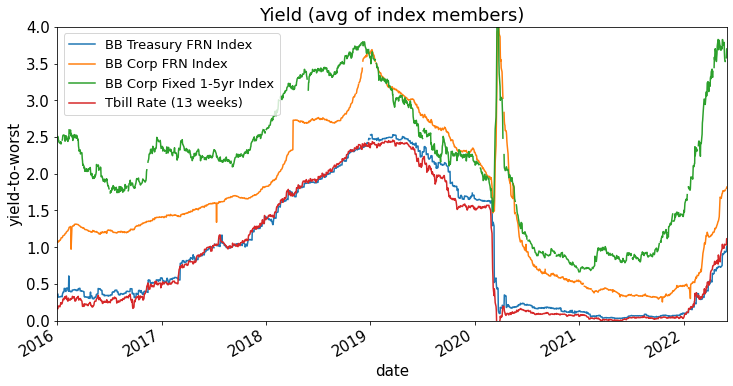

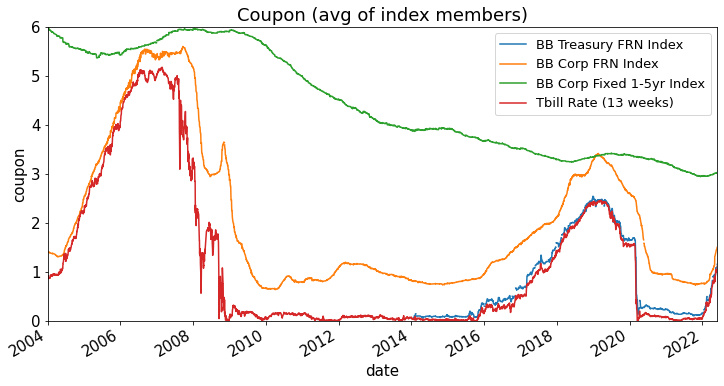

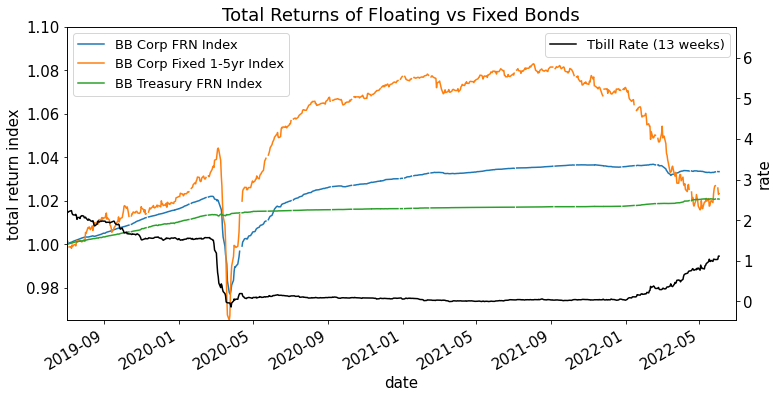

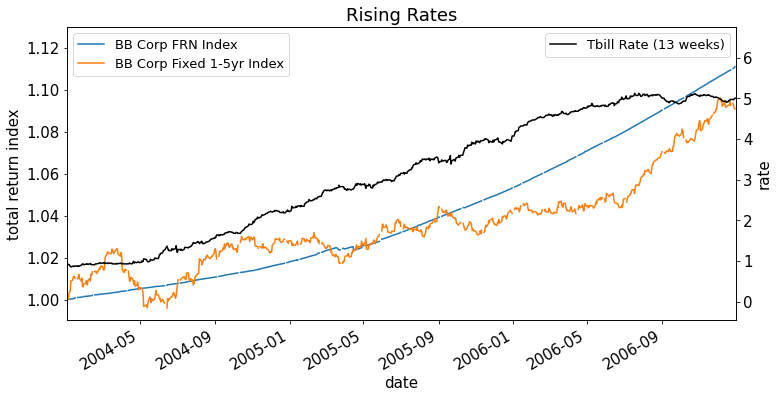

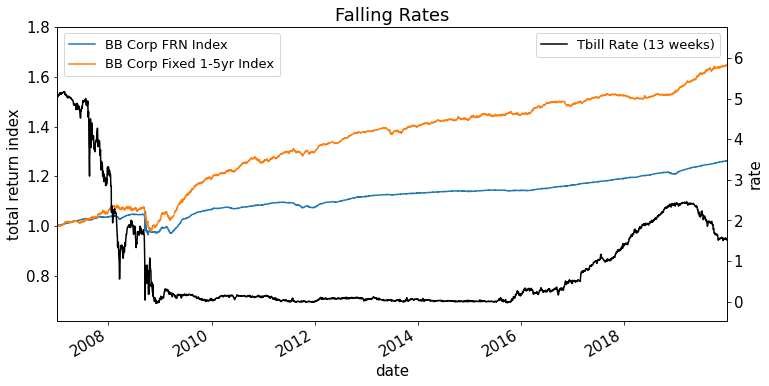

# Valuation

## Valuation at reset dates

### Price Notation

Denote the price of a floater as

$\text{price}_{\text{float}}(t,T;s)$

- a function of the current time, $t$, as well as the spread, $s$. 
- For notational simplicity, the other arguments, including reset dates and underlying reference rate, are not notated explicitly.

### Par Value
Suppose that...
- reset dates and coupon dates both occur with frequency $\kappa$.
- the floating rate is the risk-free rate associated with the discount curve, $r_\kappa(T_{i-1},T_i)$, where the subscript $\kappa$ denotes the compounding frequency
- there is no spread, $s=0$.

**The price of the floater with zero spread at reset date $T_i$ equals its face value.**

$\text{price}_{\text{float}}(T_i,T;0) = 100$

- This is the **ex-coupon** price, so the above equation indicates the price immediately after any $T_i$ coupon is paid.

### The discount rate and (floating) coupon rate are exactly offsetting!

If the rate rises, 
- this increases the coupon, 
- but it also increases the discount rate on the cashflow.
- the effects exactly offset in this model.

If the spread is non-zero, 
* price will not necessarily stay near par
* corporate bonds typically are set up close to the model above, with a spread


## Caution: Valuation with frictions

Our model above relied on the following assumptions:
- the floating rate corresponds to the risk-free rate
- the coupon is based on the floating rate in arrears
- the floating rate is based on compounding frequency equal to the coupon frequency

Without these assumptions, we do not obtain the result that price is par on reset dates.

### Nonetheless...

* prices of Treasury FRN trade very close to par.
* the models above are the dominant baseline for pricing.

## Revisiting the Example: U.S. Treasury FRNs

Above we looked at U.S. Treasury FRNs. However,

**Treasury FRNs violate several of our simple assumptions**

1. Coupon frequency differs from reset date frequency.
    - Coupons are quarterly.
    - Resets are weekly

2. Underlying rate is not the same as the discount rate
    - 13 week treasury bill rate (annualized) averaged arithmetically
    
Still, they price near par as the baseline model would suggest.

These complications have a minor impact on price.

# Swaps

### Definition

A **swap** works as follows... 
- Two counterparties agree at $t$ to swap payments on future dates.
- The payments may be based on fixed vs floating interest rates on the same currency or fixed interest rates across two currencies.
- The swap designates a **notional** base for the interest rates, but the notional is not exchanged.

### Fixed-for-Floating

A **fixed-for-floating** interest-rate swap is an agreement with the following obligations:
- Make fixed payments at an annualized rate, $\text{cpn}_\text{swap}$, on a notional $\text{notional}$, up to a maturity date $T$.
- Make payments derived from a variable short-term rate, $r(t)$.

Consider the swap:
- Exchanging payments at frequency $\kappa$, thus making payments every $\tau = 1/\kappa$.
- The interest rate quoted is compounded at frequency $\kappa$.

The cashflow, $\text{cashflow}$, at each swap period is given by:

$\begin{align}
\text{cashflow}(T_i) = \text{notional} \cdot \tau \left[r_\kappa(T_{i-1},T_i) - \text{cpn}_\text{swap}\right]
\end{align}$

### Swap Rate

The fixed rate in the fixed-for-floating swap, $\text{cpn}_\text{swap}$, is known as the **swap rate**.

Note that it is specific to
- the index underlying the floating rate
- the maturity
- the frequency of payments
- the frequency of the compounding of the rates quoted

### Specifications 

Frequency
- floating payment is often quarterly
- fixed payment is often semiannual
- SOFR or Fed Funds effective rate

### No cost to initiate

Like a forward, there is no cost to initiate the swap.
- There is no cashflow immediately.
- The swap rate is set such that the value is initially zero.
- This is a similarity to the forward, (FRA or forward contract), where the forward rate is such that the initial value is zero.

This aspect is an important part of why swaps (and forwards) have become so important for managing interest-rate risk: they allow one to change the duration of the portfolio without any up-front cost.


#### Swap as bonds
A swap can be replicated with fixed-rate and floating-rate bonds. 

Consider the **paying-fixed** swap.
* Long FRN with underlying variable rate same as the rate underlying the swap.
* Short fixed-rate bond.

The cashflows from this setup will replicate the paying-fixed swap.
* Pay the fixed rate (via short coupon of fixed-rate bond.) 
* Receive the floating rate (via long FRN.)
* At maturity, the long and short positions have offsetting face values, thus no exchange of notional.

#### Swap as forwards
- A forward can be seen as a single-date, swap.
- Thus, a swap is a portfolio of forwards.

## Swap Curve

On a given date, consider the quoted swap rate, $\text{c}_\text{swap}$, across swaps of various maturities.

This is the **swap curve**. 

Refer to end of W3 Swaps for Swap pricing formulas. 

# Week 4: Forwards

A given date's term structure encodes information about rates **in the future**.

## Example

Suppose...
- an investor will be receiving (risk-free) 100 million in six months ($T_1=1$)
- the investor wants to invest the (risk-free) for an additional six months ($T_2=2$)
- at that point, the investor will take the funds and invest them in a risky project

Consider the following...
- Today, ($t$) the investor wants to fix the interest rate earned on the 100 million between the time it is received ($T_1$) and deployed ($T_2$)
- Today, what rate can we offer to this investor, effective between $T_1$ and $T_2$?

**This forward interest rate is encoded in the time-$t$ term structure!**


In [4]:
QUOTE_DATE = '2023-05-15'

bonds = get_bond(QUOTE_DATE,maturity=[.5,1],coupon=0)
display(bonds.drop(columns=['outstanding']).style.format({'price':'{:.2f}','maturity interval':'{:.2f}','coupon rate':'{:.2%}','yld':'{:.2%}','duration':'{:.2f}'}))

,issue date,maturity date,coupon rate,yld,duration,maturity interval,price
KYTREASNO,,,,,,,
208053,2023-05-18 00:00:00,2023-11-16 00:00:00,0.00%,5.11%,0.51,0.51,97.44
208055,2023-05-18 00:00:00,2024-05-16 00:00:00,0.00%,4.65%,1.01,1.00,95.43


### The answer

The rate we can guarantee today, effective starting 6 months from now, through 12 months from now is given below.

* Sell a forward contract today ($t$) to receive 100m in 6 months for repayment in 12 months with the TBD forward interest rate.
* Simultaneously at $t$, sell short the 6mo t-bill and use the proceeds to invest in the 12mo Tbill.
* At 6mo, use the proceeds from the forward counterparty to repay the 6mo treasury.
* At 12mo, use the proceeds from the 12mo t-bill to pay off the forward loan.

We have a perfectly hedged position at all times.

Thus, the forward rate must equal the gain from the 12mo tbill.
* Note that we actually bought $$\frac{P_t^{(\text{6mo})}}{P_t^{(\text{12mo})}}$$ units of the 12mo tbill.

In [5]:
FREQ_COMPOUNDING = 2
CAPITAL = 100
FACE_VALUE = 100

Nshort = -CAPITAL / FACE_VALUE
p_1 = bonds['price'].iloc[0]
p_2 = bonds['price'].iloc[1]

hedge_ratio =  - Nshort * p_1 / p_2

cash_forward = hedge_ratio * FACE_VALUE
forward_rate = FREQ_COMPOUNDING * (cash_forward / CAPITAL - 1)

display(f'The annualized semi-annual rate offered: {forward_rate:.4%}')

label_rate = 'interest rate between $T_1$ and $T_2$'

ex_summary = pd.DataFrame({'investment at $T_1$':[100],'distribution at $T_2$':[cash_forward],\
              label_rate: [forward_rate]},\
             index=['forward investment']).T

ex_summary.style.format('{:.2f}')\
    .format(formatter='{:.2%}',subset=pd.IndexSlice[label_rate,:])\
    .applymap(lambda x: "background-color: lightcoral", subset=pd.IndexSlice[label_rate,:])

'The annualized semi-annual rate offered: 4.2190%'

,forward investment
investment at $T_1$,100.00
distribution at $T_2$,102.11
interest rate between $T_1$ and $T_2$,4.22%



### Forward Discount Factors
Define the **forward discount factor** as

$\begin{align}
F(t,T_1,T_2) = \frac{Z(t,T_2)}{Z(t,T_1)}
\end{align}$

This is the time-$t$ implied discount factor effective over $T_1$ to $T_2$.

Given this definition, answer the following:
- For $T_2=T_1$, what is $F(t,T_1,T_2) = ?$
- Is $F(t,T_1,T_2)$ increasing or decreasing in $T_2$?
- What is $F(t,t,T)$?

As we defined both a spot rate, $r(t,T)$ and equivalent discount factor, $Z(t,T)$, it is convenient to express this forward information not just as a forward discount factor, but also its equivalent rate.

### Forward Discount Rates

The **forward discount rate** is given as

$\begin{align}
f(t,T_1,T_2) \equiv & \quad -\frac{\ln\left\{F(t,T_1,T_2)\right\}}{T_2-T_1}\\[6pt]
F(t,T_1,T_2) = & \quad e^{-f(t,T_1,T_2)(T_2-T_1)}
\end{align}$

Note how the relationship between $f$ and $F$ is analogous to the relationship between $r$ and $Z$.

### Extracting the forward curve from the spot curve
Using the formulas above, calculate,

$\begin{align}
\{r(t,T_1),\, r(t,T_2)\}\Longrightarrow \{Z(t,T_1),\, Z(t,T_2)\}\Longrightarrow F(t,T_1,T_2)\Longrightarrow f(t,T_1,T_2)
\end{align}$

Apply this to data, using the following estimation:

In [8]:
quote_dates = ['2006-12-29','2018-12-31','2020-12-31','2023-05-15','2023-11-30']
MODEL = nelson_siegel
DELTA = .5
MULT = 1

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    curve_set = dict()
    for qdate in quote_dates:
        curve_set[qdate] = extract_spot_curves(qdate, model=MODEL, delta_maturity=DELTA, calc_forward=True, delta_forward_multiple=MULT)

curves_set = pd.concat(curve_set,axis=1,names=['quote date','curves'])

model_labels = {'Bootstrap':bootstrap, 'Nelson-Siegel':nelson_siegel, 'NS-Extended':nelson_siegel_extended}
model_label = list(model_labels.keys())[list(model_labels.values()).index(MODEL)]

display(f'Quoted Data: {QUOTE_DATE}.')
display(f'Model for spot curve: {model_label}.')

'Quoted Data: 2023-05-15.'

'Model for spot curve: Nelson-Siegel.'

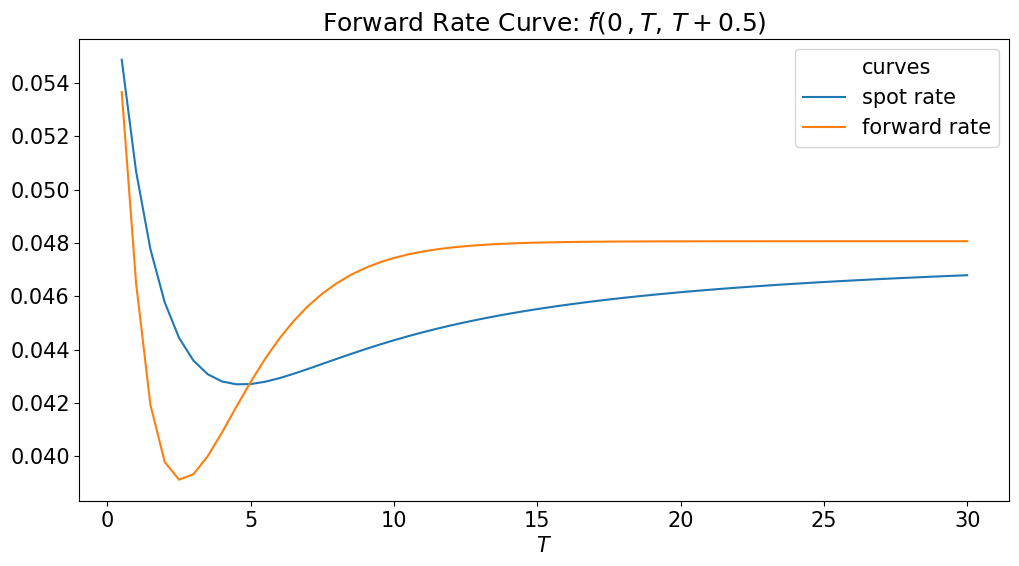

In [10]:
EXAMINE_DATE = '2023-11-30'

curves_set.iloc[0,:] = np.nan
curves = curves_set[EXAMINE_DATE]
label_title = f'Forward Rate Curve: $f(0\, ,T,\,T+{DELTA})$'
curves[['spot rate','forward rate']].plot(title=label_title, xlabel='$T$')
plt.show()

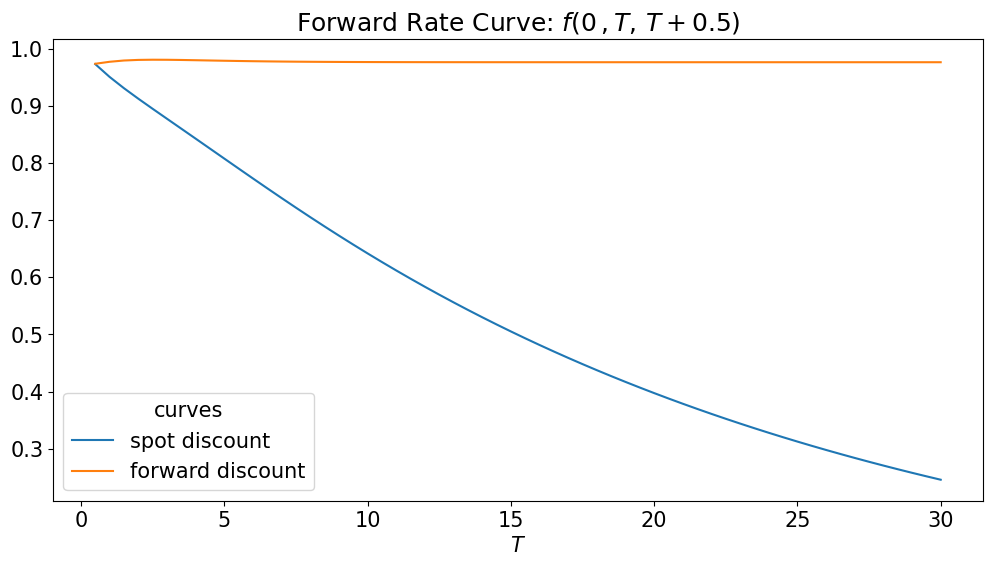

In [12]:
curves[['spot discount','forward discount']].plot(title=label_title, xlabel='$T$')
plt.show()

### Relationship between the spot curve and the forward curve

The **forward curve** is closely related to the spot curve. In one sense, the forward curve is the derivative of the spot curve, with respect to $T$, again holding $T_2-T_1$ constant at $\Delta$.

$\begin{align}
f(0,T,T+\Delta) = r(0,T) + (T+\Delta)\,\underbrace{\frac{r(0,T+\Delta)-r(0,T)}{\Delta}}_{\text{slope of spot curve}}
\end{align}$

Note then that the forward rate...
* is the spot rate plus a term that is positive (negative) if the spot curve has an increasing (decreasing) slope.
* the forward curve is above the spot curve if, and only if, the spot curve is sloping upward.

### Compounding

As for any rate, we must specify the compounding.
* $f(t,T_1,T_2)$ above is continuously compounded, as is the spot rate, $r(t,T)$.
* We could specify a compounding frequency to get

$\begin{align}
f_n(t,T_1,T_2) \equiv & \quad n\left(\frac{1}{F(t,T_1,T_2)^{\frac{1}{n(T_2-T_1)}}}-1\right)\\[6pt]
F(t,T_1,T_2) = & \quad \frac{1}{\left(1+\frac{f_n(t,T_1,T_2)}{n}\right)^{n(T_2-T_1)}}
\end{align}$

Note that
* $F$ is defined irrespective of compounding.
* Compounding only impacts the rate, $f$.
* This is analagous to $Z$ being defined absolutely and $r$ being defined with respect to a compounding frequency.

Typically, we will focus on continuously compounded forward rates, $f(t,T_1,T_2)$ as we focused on continuously compounded spot rates, $r(t,T)$.

## A Smooth Spot Curve?

Given that the forward curve is a derivative of the spot curve, a small measurement error in the spot curve may lead to large measurement error in the forward curve.

* Consider extracting the spot curve using a bootstrap instead of a model such as Nelson-Siegel.

* The spot rate and spot discount look reasonable, but their implied forward curves may oscillate in ways that suggest model error.

## Forward Rate Agreements

### Definition
A Forward Rate Agreement (FRA) is similar to the financing provided in the example above. 

There are a few differences. In an FRA, 
- the party entering the FRA does not deposit the capital. (In the example above, the investor deposits the 100mm at $T_1$.
- rather, the party entering the FRA pays the spot rate, $r(T_1,T_2)$, on the notional.

The net receipt for the investor is, using a compounding frequency, $n$,

$\begin{align}
& \quad N \Delta\left[f_n(0,T_1,T_2)-r_n(T_1,T_2)\right]\\[6pt]
\Delta \equiv & \quad T_2-T_1\\[6pt]
N \equiv & \quad \text{Notional Investment}
\end{align}$

### No-arbitrage replication

Like the forward loan described at the start of the note, the FRA can be priced with no-arbitrage replication.

Time $t$: do exactly as above
* Sell short the 6mo t-bill.
* Use the proceeds to invest in the 12mo Tbill.

Time $T_1$
* Create a new short position in a Tbill maturing at $T_2$. Size it to time-$T_1$ value of 100.
* Use the proceeds of this new short position to close out the original short position taken at time $t$.

Time $T_2$
* Use the proceeds from the 12mo t-bill to pay off the counterparty.
* Use the counterparty's interest payment based on the spot rate, $r(T_1,T_2)$ to close out the short position entered at $T_1$ and maturing at $T_2$.
* The face value of the maturing bill $(t,T_2)$ nets out the face value needed to close the $(T_1,T_2)$ short.

We have a perfectly hedged position at all times.

## Forward Contracts

### Definition
A forward contract is an agreement to buy a bond with maturity $T$...
- at a specific time in the future, $T_0$
- at a specific price, $P_{\text{Fwd}}(t,T_0,T)$

#### Note 
Here we use $T_0$ to denote the date of the forward, and $T$ to denote the date of the maturity, 
- Not $T_1$ and $T_2$ as above. 
- This is for notational convenience below.


#### Initalization
The forward price is set such that there is no price to initiate the forward contract. 
* That is, the value to the contract is 0 at initialization

#### Final payoff
The final payoff from the long forward contract on the bond is, (at $T_0$)

$\begin{align}
V_{\text{Fwd}}(T_0,T) = P(T_0,T) - P_{\text{Fwd}}(0,T_0,T)
\end{align}$

### Price vs Value
Like with FRAs, it is important to carefully distinguish the **forward price** from the **value** of an FRA or **value** of a forward contract.

The initial **price** of the forward contract is set such that the **value** is zero.

Thereafter, 
* the **value** of the contract will move with interest rates.

* the **forward price** is a contract parameter and will be effective at $T_0$

At an interim time $0<t<T_0$, we have the following formula for the value of a forward contract on a treasury bond:

$\begin{align}
V_{\text{Fwd}}(t,T_0,T) = Z(t,T_0)\left[P_{\text{Fwd}}(t,T_0,T) - P_{\text{Fwd}}(0,T_0,T)\right]
\end{align}$

This equation simply says that the interim value is 
* what it would cost to enter an offsetting short forward
* netted against the price already promised at $t=0$
* discounted back to $t$, as these payments will happen at $T_0$.

Note that this interim value will vary with interest rates, as they impact $P(t,T)$.

In [16]:
p_forward_contract = curves['forward discount'].loc[.5]
n_forward_contracts = CAPITAL / p_forward_contract

payment = p_forward_contract * n_forward_contracts
payoff = n_forward_contracts 

annualized_semiannual_forward_rate = (payoff / CAPITAL - 1)*2

frate_cont = curves['forward rate'].loc[.5]
frate_semi = compound_rate(curves['forward rate'],None,2).loc[.5]

tab_ex_prices = pd.DataFrame([['contracted forward price',p_forward_contract],\
            ['number of forward contracts',n_forward_contracts],\
            ['payment at $T_0$',payment],\
            ['payoff at $T$',payoff]])

tab_ex_rates = pd.DataFrame([\
                    ['annualized return from $T_0$ to $T$', annualized_semiannual_forward_rate],\
                    ['forward rate (continuous)',frate_cont],\
                    ['forward rate (semiannual)',frate_semi]])

tab_ex_prices.columns = ['','value']
tab_ex_prices.set_index('',inplace=True)

tab_ex_rates.columns = ['','value']
tab_ex_rates.set_index('',inplace=True)

index_rates = tab_ex_rates.index
index_highlight = index_rates[[0,2]]

display(pd.concat([tab_ex_prices,tab_ex_rates],axis=0).style.format("{:.4f}")\
    .format(formatter='{:.4%}',subset=pd.IndexSlice[index_rates,:])\
    .applymap(lambda x: "background-color: lightcoral", subset=pd.IndexSlice[index_highlight,:]))

,value
,
contracted forward price,0.9735
number of forward contracts,102.7191
payment at $T_0$,100.0000
payoff at $T$,102.7191
annualized return from $T_0$ to $T$,5.4382%
forward rate (continuous),5.3656%
forward rate (semiannual),5.4382%
